In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_predict,cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('ddos.csv')

num_rows = len(df.index) #satır
num_cols = len(df.columns) #sütun

print("Satır sayısı:", num_rows)
print("Sütun sayısı:", num_cols)
df.columns = df.columns.str.strip() #sütun adındaki gereksiz boşlukları kaldırır
unique_labels = df.loc[:,'Label'].unique() #tekrarlanan değerleri kaldırıp sadece unique olanları listeler
print("Unique labels:", unique_labels)


Satır sayısı: 225745
Sütun sayısı: 79
Unique labels: ['BENIGN' 'DDoS']


In [3]:
# Çıkarılacak sütunların listesi
columns_to_drop = [
    'Fwd Header Length.1', 'Flow Bytes/s', 'Flow Packets/s',
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
    'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'
]

# Sütunları çıkarma
df = df.drop(columns=columns_to_drop)

df.head(3)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
data_f=df.dropna()
data_f['Label'] = data_f['Label'].map({'BENIGN': 0, 'DDoS': 1})

BENIGN sayısı: 97718
DDoS sayısı: 128027


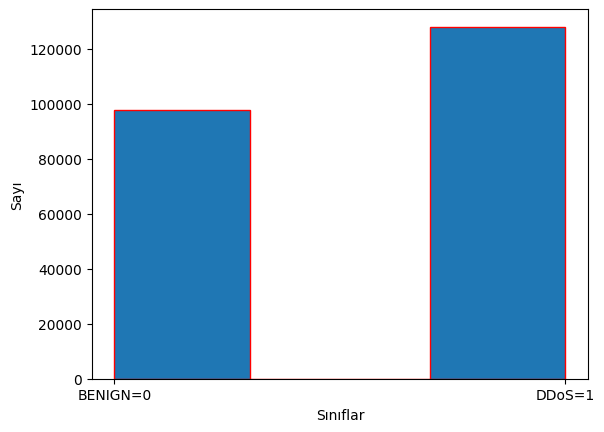

In [5]:
class_counts = data_f['Label'].value_counts()
print("BENIGN sayısı:", class_counts[0])
print("DDoS sayısı:", class_counts[1])

plt.hist(data_f['Label'], bins=[0, 0.3,0.7,1], edgecolor='red') 
plt.xticks([0, 1], labels=['BENIGN=0', 'DDoS=1'])
plt.xlabel("Sınıflar")
plt.ylabel("Sayı")
plt.show()


In [6]:
# Veriyi X ve y olarak ayırma
X = data_f.drop('Label', axis=1)
y = data_f['Label']
# Inf ve -Inf değerlerini NaN olarak ayarla
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN değerlerini içeren satırları veri setinden çıkar
X.dropna(inplace=True)

# Satırların unique olup olmadığını kontrol et
is_unique = X.duplicated().sum() == 0

if is_unique:
    print("Veri setinde tekrarlanan satır yok.")
else:
    duplicated_count = X.duplicated().sum()
    print(f"Veri setinde {duplicated_count} tekrarlanan satır var.")
    # Tekrarlanan satırları kaldır
    X.drop_duplicates(inplace=True)
    print("Tekrarlanan satırlar kaldırıldı.")
    
# Kalan satır sayısını yazdır
remaining_rows = len(X)
print(f"Kalan satır sayısı: {remaining_rows}")

# Hedef değişkenin (Label) de aynı satırlarla tutarlı olmasını sağla
y = y[X.index]

Veri setinde 2633 tekrarlanan satır var.
Tekrarlanan satırlar kaldırıldı.
Kalan satır sayısı: 223112


In [7]:
# Veriyi standartlaştırma
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# # PCA ile boyut azaltma
# pca = PCA(n_components=0.95)  # Varyansın %95'ini koruyarak boyut azaltma
# X_pca = pca.fit_transform(X_scaled)

In [9]:
# # Cross-validation için hazırlık
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Modellerin tanımlanması
# xgb_model = XGBClassifier()
# svm_model = SVC(probability=True)
# knn_model = KNeighborsClassifier()
# dt_model = DecisionTreeClassifier()

# # Sonuçları saklamak için boş listeler
# xgb_probas = []
# svm_probas = []
# knn_probas = []
# dt_probas = []
# cnn_probas = []
# mlp_probas = []

In [10]:
#veri setindeki özelliklerin boyutunu azaltma
pca = PCA(n_components=40) #40 bileşene indirgeme
X_pca = pca.fit_transform(X_scaled) #eğitim ve yeni bileşenlere dönüştürme
print("Açıklanan varyans oranları:", pca.explained_variance_ratio_) #her bir bileşenin veri setindeki toplam varyansın ne kadarını açıkladığı


Açıklanan varyans oranları: [2.25392607e-01 1.52613325e-01 1.28394806e-01 9.56593321e-02
 4.97233864e-02 4.02440231e-02 3.68521395e-02 3.12697664e-02
 2.74953705e-02 2.29032553e-02 2.11650799e-02 1.85652336e-02
 1.81584312e-02 1.62615041e-02 1.53347708e-02 1.50474354e-02
 1.29948319e-02 1.17464820e-02 8.69528201e-03 7.84199375e-03
 6.32308742e-03 5.56754880e-03 4.98483532e-03 4.57172939e-03
 4.22971446e-03 3.70617212e-03 2.83355852e-03 2.07533893e-03
 1.58584998e-03 1.51339803e-03 1.36154654e-03 9.85301778e-04
 6.55523095e-04 6.08667257e-04 5.05574695e-04 4.78131697e-04
 3.68341873e-04 2.92502497e-04 2.44069029e-04 2.07703133e-04]


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# # Cross-validation kullanarak model performansını değerlendirme
# predictions_xgb = cross_val_score(xgb_model, X_pca, y, cv=cv)

# # report_xgb = classification_report(y, predictions_xgb)
# # print("XGBoost Sınıflandırma Raporu:\n", report_xgb)

# # Model performansını raporlama
# print("Ortalama Doğruluk Skoru:", predictions_xgb.mean())
# print("XGBoost Sınıflandırma Raporu:\n", classification_report(y, cross_val_predict(xgb_model, X_pca, y)))  #10 saniye

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}

In [14]:
#MLP modeli
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state=42)

results_mlp = cross_validate(mlp_model, X_pca, y, cv=cv, scoring=scoring)
print('\nMLP Cross-Validation Değerlendirme Metrikleri:')
print(f"Accuracy: {np.mean(results_mlp['test_accuracy'])}")
print(f"F1 Score: {np.mean(results_mlp['test_f1'])}")
print(f"Precision: {np.mean(results_mlp['test_precision'])}")
print(f"Recall: {np.mean(results_mlp['test_recall'])}")


MLP Cross-Validation Değerlendirme Metrikleri:
Accuracy: 0.9996235077170852
F1 Score: 0.9996151221483857
Precision: 0.9996246200711495
Recall: 0.9996056636879583


In [15]:
# XGBClassifier modelini tanımlama
xgb_model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, reg_alpha=0.1, reg_lambda=1)

results_xgb = cross_validate(xgb_model, X_pca, y, cv=cv, scoring=scoring)
print('\nXGBoost Cross-Validation Değerlendirme Metrikleri:')
print(f"Accuracy: {np.mean(results_xgb['test_accuracy'])}")
print(f"F1 Score: {np.mean(results_xgb['test_f1'])}")
print(f"Precision: {np.mean(results_xgb['test_precision'])}")
print(f"Recall: {np.mean(results_xgb['test_recall'])}") #10 saniye


XGBoost Cross-Validation Değerlendirme Metrikleri:
Accuracy: 0.9994935284967432
F1 Score: 0.9994822857367573
Precision: 0.9994574575146205
Recall: 0.9995072688963017


In [16]:
# DT modelini oluştur
dt_model = DecisionTreeClassifier(max_depth=3, min_samples_split=10, min_samples_leaf=5)

# Model performansını raporla
# predictions_dt = cross_val_predict(dt_model, X_pca, y, cv=cv)
# report_dt = classification_report(y, predictions_dt)
# print("DT Ortalama Doğruluk Skoru:", predictions_dt.mean())
# print("Decision Tree Sınıflandırma Raporu:\n", report_dt) #90 saniye

results_dt = cross_validate(dt_model, X_pca, y, cv=5,scoring=scoring)
print('\nDecision Tree Cross-Validation Değerlendirme Metrikleri:')
print(f"Accuracy: {np.mean(results_dt['test_accuracy'])}")
print(f"F1 Score: {np.mean(results_dt['test_f1'])}")
print(f"Precision: {np.mean(results_dt['test_precision'])}")
print(f"Recall: {np.mean(results_dt['test_recall'])}") #20 saniye



Decision Tree Cross-Validation Değerlendirme Metrikleri:
Accuracy: 0.9370136118523019
F1 Score: 0.9348719807399677
Precision: 0.9425240530183183
Recall: 0.931672446003034


In [17]:
# KNN modelini oluştur
knn_model = KNeighborsClassifier(n_neighbors=10)

# # Model performansını raporla
# predictions_knn = cross_val_predict(knn_model, X_pca, y)
# report_knn = classification_report(y, predictions_knn)
# print("KNN Ortalama Doğruluk Skoru:", predictions_knn.mean())
# print("KNN Sınıflandırma Raporu:\n", report_knn) #130 saniye

results_knn = cross_validate(knn_model, X_pca, y, cv=cv, scoring=scoring)
print('\nKNN Cross-Validation Değerlendirme Metrikleri:')
print(f"Accuracy: {np.mean(results_knn['test_accuracy'])}")
print(f"F1 Score: {np.mean(results_knn['test_f1'])}")
print(f"Precision: {np.mean(results_knn['test_precision'])}")
print(f"Recall: {np.mean(results_knn['test_recall'])}") # 160 saniye


KNN Cross-Validation Değerlendirme Metrikleri:
Accuracy: 0.9996145434285728
F1 Score: 0.9996059652601433
Precision: 0.9996059843328162
Recall: 0.9996059646257125


In [ ]:
# SVM modelini oluştur
svm_model = SVC(probability=True,kernel='rbf', C=1, gamma='scale',)

# # Model performansını raporla
# predictions_svm = cross_val_predict(svm_model, X_pca, y, cv=5)
# report_svm = classification_report(y, predictions_svm)
# print("SVM Ortalama Doğruluk Skoru:", predictions_svm.mean())
# print("SVM Sınıflandırma Raporu:\n", report_svm) #8000 saniye

results_svm = cross_validate(svm_model, X_pca, y, cv=cv, scoring=scoring)
print('\nSVM Cross-Validation Değerlendirme Metrikleri:')
print(f"Accuracy: {np.mean(results_svm['test_accuracy'])}")
print(f"F1 Score: {np.mean(results_svm['test_f1'])}")
print(f"Precision: {np.mean(results_svm['test_precision'])}")
print(f"Recall: {np.mean(results_svm['test_recall'])}") #1300 saniye



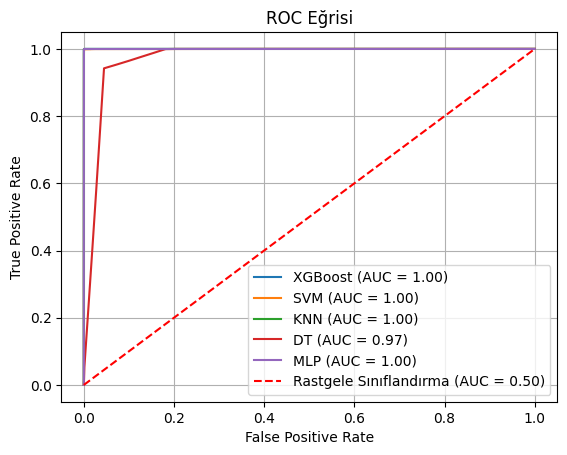

In [14]:

dt_model = DecisionTreeClassifier(max_depth=3, min_samples_split=10, min_samples_leaf=5)
xgb_model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, reg_alpha=0.1, reg_lambda=1)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=10)

svm_model = SVC(probability=True,kernel='rbf', C=1, gamma='scale',)



xgb_proba = cross_val_predict(xgb_model, X_pca, y, cv=cv, method='predict_proba')
svm_proba = cross_val_predict(svm_model, X_pca, y, cv=cv, method='predict_proba')
knn_proba = cross_val_predict(knn_model, X_pca, y, cv=cv, method='predict_proba')
dt_proba =  cross_val_predict(dt_model, X_pca, y, cv=cv, method='predict_proba')
mlp_proba = cross_val_predict(mlp_model, X_pca, y, cv=cv, method='predict_proba')

# ROC eğrisi hesaplamaları
xgb_fpr, xgb_tpr, _ = roc_curve(y, xgb_proba[:, 1])
xgb_auc = auc(xgb_fpr, xgb_tpr)

svm_fpr, svm_tpr, _ = roc_curve(y, svm_proba[:, 1])
svm_auc = auc(svm_fpr, svm_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y, knn_proba[:, 1])
knn_auc = auc(knn_fpr, knn_tpr)

dt_fpr, dt_tpr, _ = roc_curve(y, dt_proba[:, 1])
dt_auc = auc(dt_fpr, dt_tpr)

mlp_fpr, mlp_tpr, _ = roc_curve(y, mlp_proba[:, 1])
mlp_auc = auc(mlp_fpr, mlp_tpr)

# ROC eğrisi çizimi
plt.figure()
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {knn_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'DT (AUC = {dt_auc:.2f})')
plt.plot(mlp_fpr, mlp_tpr, label=f'MLP (AUC = {mlp_auc:.2f})')



# Rastgele sınıflandırma için ROC eğrisi
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Rastgele Sınıflandırma (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend()
plt.grid()
plt.show()

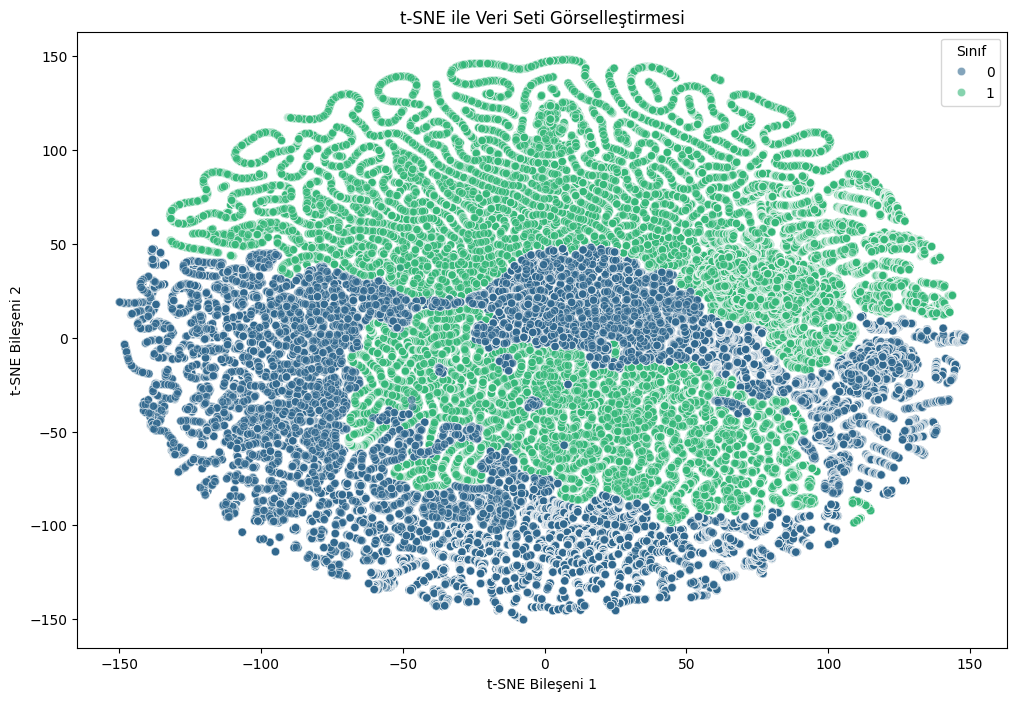

In [20]:
from sklearn.manifold import TSNE
import seaborn as sns
# t-SNE ile boyut indirgeme ve görselleştirme
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', alpha=0.6)
plt.title('t-SNE ile Veri Seti Görselleştirmesi')
plt.xlabel('t-SNE Bileşeni 1')
plt.ylabel('t-SNE Bileşeni 2')
plt.legend(title='Sınıf')
plt.show()